In [135]:
#!pip install PyPDF2 pandas nltk textblob wordcloud scikit-learn gensim matplotlib

## Import Libraries

In [136]:
import PyPDF2
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim import corpora,models
import matplotlib.pyplot as plt
import os
import pypdf
import seaborn as sns

In [137]:

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##Import PDF and Read All Pages

In [83]:
pdf_path = r"/content/BSL Annual Report 2024-25.pdf"
output_path = r"D:\NMIMS\4th year\Sem 7\NLP\output"
os.makedirs(output_path, exist_ok=True)

In [84]:
reader = pypdf.PdfReader(open(pdf_path, 'rb')) # Use pypdf.PdfReader
text_pages = []
for i, page in enumerate(reader.pages):
  text = page.extract_text()
  if text:
    text_pages.append({'page_num': i+1, 'text': text})

In [85]:
df = pd.DataFrame(text_pages)
print("PDF Imported. Total pages:",len(df))

PDF Imported. Total pages: 396


##Preprocess Text

In [86]:
stop_words = set(stopwords.words('english'))

In [87]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '',text)
  text = re.sub(r'\s+',' ',text).strip()
  # tokens = word_tokenize(text) # Removed word tokenization due to missing resource
  tokens = [w for w in text.split() if w not in stop_words and len(w) > 2] # Use split() instead of word_tokenize
  return " ".join(tokens)

In [88]:
df['clean_text'] = df['text'].apply(clean_text)
print("Text Cleaned and Preprocessed")

Text Cleaned and Preprocessed


##Sentence Tokenization and Sentiment (TextBlob)

In [89]:
sentences = []
for page in df['text']:
  for sent in sent_tokenize(page):
    blob = TextBlob(sent)
    sentences.append({
        'sentence' : sent,
        'polarity' : blob.sentiment.polarity,
        'subjectivity' : blob.sentiment.subjectivity
    })


In [90]:
sent_df = pd.DataFrame(sentences)
print("Sentiment Calculated for Each Sentence")

Sentiment Calculated for Each Sentence


In [91]:
# Sentiment summary
print("\nSentiment summary:")
print(sent_df['polarity'].describe())


Sentiment summary:
count    4994.000000
mean        0.045268
std         0.144576
min        -0.800000
25%         0.000000
50%         0.000000
75%         0.062500
max         1.000000
Name: polarity, dtype: float64


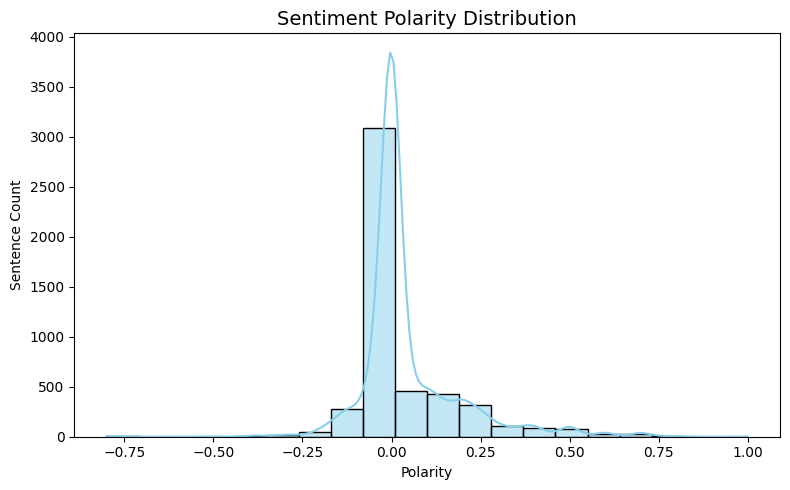

In [92]:
# Visualize sentiment Distribution
plt.figure(figsize=(8, 5))
sns.histplot(sent_df['polarity'], bins=20, kde=True, color='skyblue')
plt.title("Sentiment Polarity Distribution", fontsize=14)
plt.xlabel("Polarity")
plt.ylabel("Sentence Count")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "sentiment_distribution.png"))
plt.show()

In [93]:
print("Overall Average Polarity", sent_df['polarity'].mean())
print("Average Subjectivity:", sent_df['subjectivity'].mean())

Overall Average Polarity 0.04526767023650785
Average Subjectivity: 0.23028600900388926


##Word Tokenization & Preprocess for Word Frequency

In [110]:
all_words = []
for t in df['clean_text']:
  all_words.extend(t.split())

word_freq = pd.Series(all_words).value_counts().head(20)
print("\nTop 20 Frequent Words:\n", word_freq)


Top 20 Frequent Words:
 financial      1195
march          1139
blue           1094
year           1058
star           1006
company         985
limited         682
statements      533
assets          478
total           478
crores          477
ended           455
management      329
value           324
report          322
tax             318
board           310
group           307
liabilities     285
business        285
Name: count, dtype: int64


/tmp/ipython-input-3452424051.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




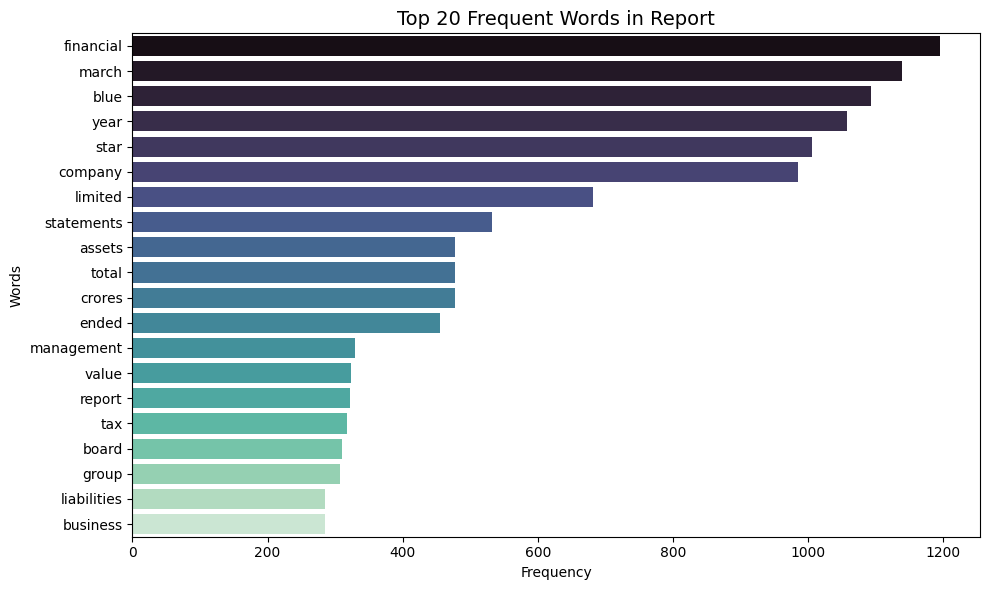

In [111]:
plt.figure(figsize=(10, 6))
sns.barplot(x=word_freq.values, y=word_freq.index, palette='mako')
plt.title("Top 20 Frequent Words in Report", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "word_frequency.png"))
plt.show()

##WordCloud Visualization

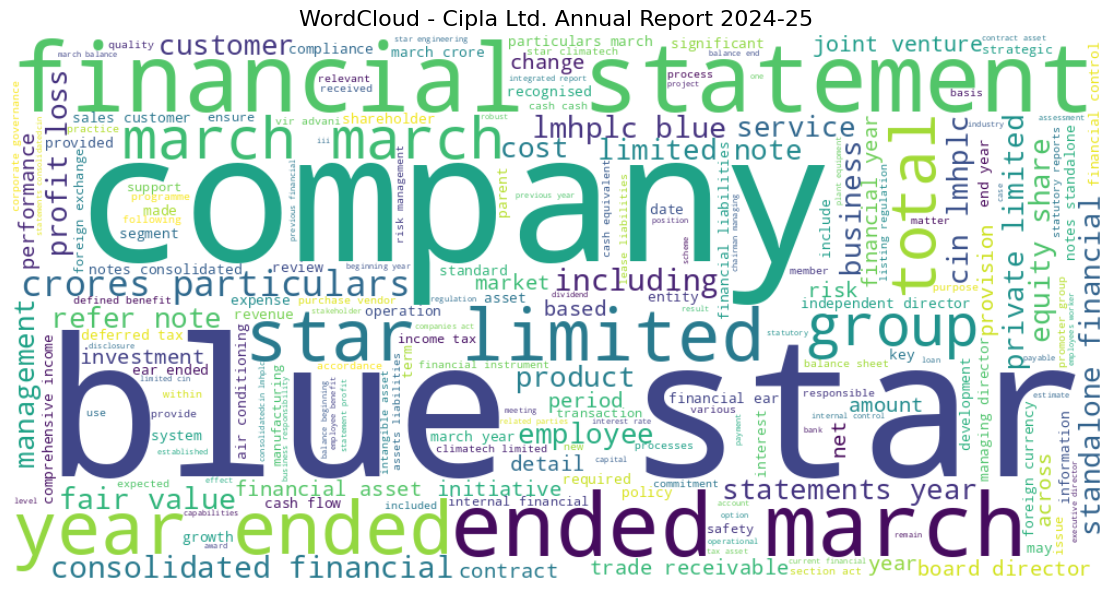

In [96]:
wc = WordCloud(width=1000, height=500, background_color='white').generate(" ".join(all_words))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Cipla Ltd. Annual Report 2024-25", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "wordcloud.png"))
plt.show()

##Convert to TF-IDF Matrix or Document-Term Matrix

In [97]:
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['clean_text'])
print("TF-IDF Matrix Created:", tfidf_matrix.shape)

TF-IDF Matrix Created: (396, 1000)


## Topic Modeling (LDA with Gibbs Sampling)

In [98]:
# Prepare data for Gensim
tokenized_docs = [doc.split() for doc in df['clean_text']]
dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [99]:
# Build LDA model
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=42,
    passes=10,
    update_every=1,
    chunksize=100,
    alpha='auto',
    eta='auto'
)

In [101]:
topics = lda_model.show_topics(num_topics=10, num_words=8, formatted=False)
topic_data = []
for idx, topic in topics:
    topic_words = ", ".join([w for w, _ in topic])
    topic_data.append({"Topic": f"Topic {idx + 1}", "Words": topic_words})

topic_df = pd.DataFrame(topic_data)
print("\n Top 10 Topics:\n")
print(topic_df)


 Top 10 Topics:

      Topic                                              Words
0   Topic 1  blue, star, company, business, air, across, pr...
1   Topic 2  energy, waste, total, water, intensity, scope,...
2   Topic 3  risk, governance, safety, compliance, risks, m...
3   Topic 4  bsq, students, delhi, stem, amb, kala, freezer...
4   Topic 5  company, director, board, directors, limited, ...
5   Topic 6  haul, circles, wow, ankleshwar, excels, thorou...
6   Topic 7  march, year, financial, ended, crores, tax, li...
7   Topic 8  risk, financial, assets, based, management, ex...
8   Topic 9  ear, total, employees, workers, units, permane...
9  Topic 10  financial, star, blue, limited, assets, statem...


/tmp/ipython-input-836882216.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"Topic {i+1}" for i in range(10)],


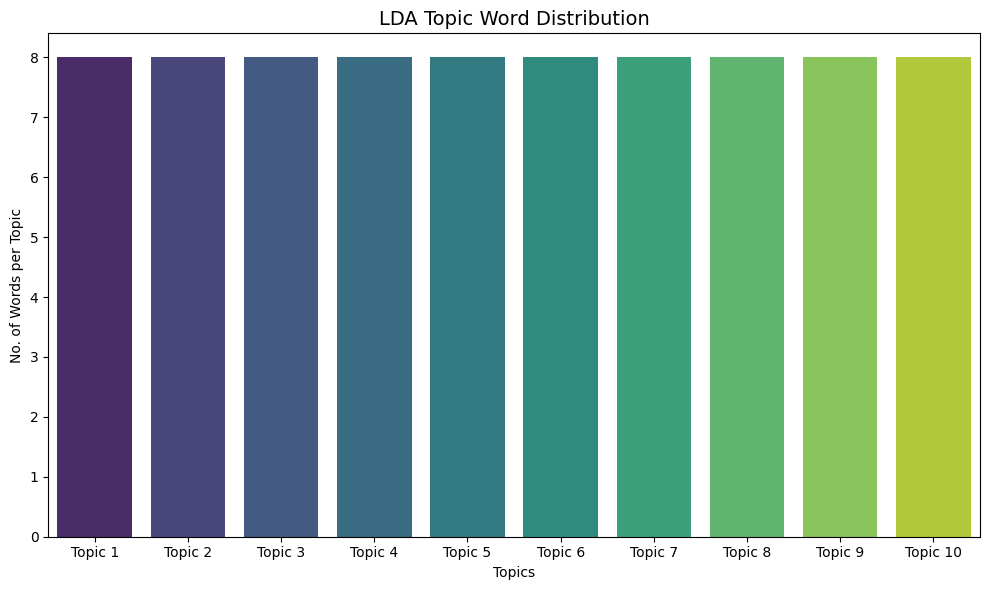

In [105]:
# Plot Topic Word Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=[f"Topic {i+1}" for i in range(10)],
            y=[len(words.split(",")) for words in topic_df["Words"]],
            palette="viridis",
            hue=None,
            legend=False
)
plt.title("LDA Topic Word Distribution", fontsize=14)
plt.xlabel("Topics")
plt.ylabel("No. of Words per Topic")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "lda_topics.png"))
plt.show()

In [108]:
sent_df.to_csv(os.path.join(output_path, "sentence_sentiment.csv"), index=False)
df.to_csv(os.path.join(output_path, "cleaned_text.csv"), index=False)
word_freq.to_csv(os.path.join(output_path, "word_frequency.csv"))
topic_df.to_csv(os.path.join(output_path, "lda_topics.csv"), index=False)

print("\nAll outputs successfully saved in:", output_path)
print("sentence_sentiment.csv")
print("cleaned_text.csv")
print("word_frequency.csv")
print("wordcloud.png")
print("sentiment_distribution.png")
print("lda_topics.png")
print("lda_topics.csv")


All outputs successfully saved in: D:\NMIMS\4th year\Sem 7\NLP\output
sentence_sentiment.csv
cleaned_text.csv
word_frequency.csv
wordcloud.png
sentiment_distribution.png
lda_topics.png
lda_topics.csv
